In [2]:
!pip install tqdm
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.4 MB/s eta 0:00:00


In [3]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 3.9 MB/s eta 0:00:00


In [4]:
!pip install matplotlib

In [5]:
import pickle
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import numpy as np
import scipy.signal as sg
import wfdb
import torch
from sklearn.metrics import classification_report, confusion_matrix
from skorch import NeuralNetClassifier
import cv2
import pywt
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Initializer, LRScheduler, TensorBoard
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from torch.backends import cudnn
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


Data preprocessing and load train test dataset

In [8]:
PATH = Path("MIT-BIHArrhythmiaDatabase")
sampling_rate = 360

# Non-beat labels
invalid_labels = ['|', '~', '!', '+', '[', ']', '"', 'x']

# For correct R-peak location
tol = 0.05


def worker(record):
    # Read ML II signal & r-peaks position and labels
    signal = wfdb.rdrecord((PATH / record).as_posix(), channels=[0]).p_signal[:, 0]

    annotation = wfdb.rdann((PATH / record).as_posix(), extension="atr")
    r_peaks, labels = annotation.sample, np.array(annotation.symbol)

    # Filtering uses a 200-ms width median filter and 600-ms width median filter
    baseline = sg.medfilt(sg.medfilt(signal, int(0.2 * sampling_rate) - 1), int(0.6 * sampling_rate) - 1)
    filtered_signal = signal - baseline

    # Remove non-beat labels
    indices = [i for i, label in enumerate(labels) if label not in invalid_labels]
    r_peaks, labels = r_peaks[indices], labels[indices]

    # Align r-peaks
    newR = []
    for r_peak in r_peaks:
        r_left = np.maximum(r_peak - int(tol * sampling_rate), 0)
        r_right = np.minimum(r_peak + int(tol * sampling_rate), len(filtered_signal))
        newR.append(r_left + np.argmax(filtered_signal[r_left:r_right]))
    r_peaks = np.array(newR, dtype="int")

    # Remove inter-patient variation
    normalized_signal = filtered_signal / np.mean(filtered_signal[r_peaks])

    # AAMI categories
    AAMI = {
        "N": 0, "L": 0, "R": 0, "e": 0, "j": 0,  # N
        "A": 1, "a": 1, "S": 1, "J": 1,  # SVEB
        "V": 2, "E": 2,  # VEB
        "F": 3,  # F
        "/": 4, "f": 4, "Q": 4  # Q
    }
    categories = [AAMI[label] for label in labels]

    return {
        "record": record,
        "signal": normalized_signal, "r_peaks": r_peaks, "categories": categories
    }


cpus = 22 if joblib.cpu_count() > 22 else joblib.cpu_count() - 1

train_records = [
        '101', '106', '108', '109', '112', '114', '115', '116', '118', '119',
        '122', '124', '201', '203', '205', '207', '208', '209', '215', '220',
        '223', '230'
]
print("train processing...")
with ProcessPoolExecutor(max_workers=cpus) as executor:
  train_data = [result for result in executor.map(worker, train_records)]

test_records = [
  '100', '103', '105', '111', '113', '117', '121', '123', '200', '202',
  '210', '212', '213', '214', '219', '221', '222', '228', '231', '232',
  '233', '234'
]
print("test processing...")
with ProcessPoolExecutor(max_workers=cpus) as executor:
  test_data = [result for result in executor.map(worker, test_records)]

with open((PATH / "mitdb.pkl").as_posix(), "wb") as f:
  pickle.dump((train_data, test_data), f, protocol=4)

print("Đã hoàn thành")

train processing...
test processing...
Đã hoàn thành


Feauture Extraction and RR Intervals

In [9]:
def worker(data, wavelet, scales, sampling_period):
    # Heartbeat segmentation interval
    before, after = 90, 110

    coeffs, frequencies = pywt.cwt(data["signal"], scales, wavelet, sampling_period)
    r_peaks, categories = data["r_peaks"], data["categories"]

    # For remove inter-patient variation
    avg_rri = np.mean(np.diff(r_peaks))

    x1, x2, y, groups = [], [], [], []
    for i in range(len(r_peaks)):
        if i == 0 or i == len(r_peaks) - 1:
            continue

        if categories[i] == 4:  # remove AAMI Q class
            continue

        # Cv2.resize is used to sampling the scalogram to (100 x100)
        x1.append(cv2.resize(coeffs[:, r_peaks[i] - before: r_peaks[i] + after], (100, 100)))
        x2.append([
            r_peaks[i] - r_peaks[i - 1] - avg_rri,  # previous RR Interval
            r_peaks[i + 1] - r_peaks[i] - avg_rri,  # post RR Interval
            (r_peaks[i] - r_peaks[i - 1]) / (r_peaks[i + 1] - r_peaks[i]),  # ratio RR Interval
            np.mean(np.diff(r_peaks[np.maximum(i - 10, 0):i + 1])) - avg_rri  # local RR Interval
        ])
        y.append(categories[i])
        groups.append(data["record"])

    return x1, x2, y, groups

Chuẩn bị dữ liệu

In [10]:
def load_data(wavelet, scales, sampling_rate, filename="./MIT-BIHArrhythmiaDatabase/mitdb.pkl"):
    import pickle
    from sklearn.preprocessing import RobustScaler

    with open(filename, "rb") as f:
        train_data, test_data = pickle.load(f)

    cpus = 22 if joblib.cpu_count() > 22 else joblib.cpu_count() - 1  # for multi-process

    # For training
    x1_train, x2_train, y_train, groups_train = [], [], [], []
    with ProcessPoolExecutor(max_workers=cpus) as executor:
        for x1, x2, y, groups in executor.map(
                partial(worker, wavelet=wavelet, scales=scales, sampling_period=1. / sampling_rate), train_data):
            x1_train.append(x1)
            x2_train.append(x2)
            y_train.append(y)
            groups_train.append(groups)

    x1_train = np.expand_dims(np.concatenate(x1_train, axis=0), axis=1).astype(np.float32)
    x2_train = np.concatenate(x2_train, axis=0).astype(np.float32)
    y_train = np.concatenate(y_train, axis=0).astype(np.int64)
    groups_train = np.concatenate(groups_train, axis=0)

    # For test
    x1_test, x2_test, y_test, groups_test = [], [], [], []
    with ProcessPoolExecutor(max_workers=cpus) as executor:
        for x1, x2, y, groups in executor.map(
                partial(worker, wavelet=wavelet, scales=scales, sampling_period=1. / sampling_rate), test_data):
            x1_test.append(x1)
            x2_test.append(x2)
            y_test.append(y)
            groups_test.append(groups)

    x1_test = np.expand_dims(np.concatenate(x1_test, axis=0), axis=1).astype(np.float32)
    x2_test = np.concatenate(x2_test, axis=0).astype(np.float32)
    y_test = np.concatenate(y_test, axis=0).astype(np.int64)
    groups_test = np.concatenate(groups_test, axis=0)

    # Normalization
    scaler = RobustScaler()
    x2_train = scaler.fit_transform(x2_train)
    x2_test = scaler.transform(x2_test)

    return (x1_train, x2_train, y_train, groups_train), (x1_test, x2_test, y_test, groups_test)

In [11]:
sampling_rate = 360
wavelet = "mexh"  # mexh, morl, gaus8, gaus4
scales = pywt.central_frequency(wavelet) * sampling_rate / np.arange(1, 101, 1)

(x1_train, x2_train, y_train, groups_train), (x1_test, x2_test, y_test, groups_test) = load_data(
        wavelet=wavelet, scales=scales, sampling_rate=sampling_rate)

EDA

In [12]:
print("Shapes:")
print("x1_train:", x1_train.shape)
print("x2_train:", x2_train.shape)
print("y_train:", y_train.shape)
print("groups_train:", groups_train.shape)

print("\nData Types:")
print("x1_train dtype:", x1_train.dtype)
print("x2_train dtype:", x2_train.dtype)
print("y_train dtype:", y_train.dtype)
print("groups_train dtype:", groups_train.dtype)

Shapes:
x1_train: (50969, 1, 100, 100)
x2_train: (50969, 4)
y_train: (50969,)
groups_train: (50969,)

Data Types:
x1_train dtype: float32
x2_train dtype: float32
y_train dtype: int64
groups_train dtype: <U3


In [13]:
x1_train

array([[[[-2.57300516e-03,  7.65240705e-03,  2.09828932e-02, ...,
          -2.47571364e-01, -2.46996209e-01, -2.52641082e-01],
         [-2.68765986e-01, -2.51127183e-01, -2.39849687e-01, ...,
           1.71551645e-01,  1.88452169e-01,  2.01799691e-01],
         [-1.51551172e-01, -1.54293314e-01, -1.49647593e-01, ...,
           4.88171577e-01,  4.87012506e-01,  4.76853341e-01],
         ...,
         [-4.71470924e-03,  8.94187717e-04,  7.01731863e-03, ...,
           5.27651457e-04,  1.02346181e-03,  1.38520764e-03],
         [-5.01075387e-03,  4.67803242e-04,  7.85280578e-03, ...,
           5.35219617e-04,  1.22274493e-03,  1.03806169e-03],
         [-5.31727262e-03,  1.40880016e-04,  8.57693888e-03, ...,
           5.64187707e-04,  1.40485947e-03,  6.63025305e-04]]],


       [[[-2.51534451e-02, -1.24811297e-02,  2.39587575e-03, ...,
          -2.67542526e-02, -2.59760208e-02, -3.44835036e-02],
         [-2.18906209e-01, -1.99807525e-01, -1.86918721e-01, ...,
           3.5519495

In [14]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
groups_train

array(['101', '101', '101', ..., '230', '230', '230'], dtype='<U3')

In [16]:
# Load header file
record = wfdb.rdheader('MIT-BIHArrhythmiaDatabase/100')

# Load data file
signals, fields = wfdb.rdsamp('MIT-BIHArrhythmiaDatabase/100')

# Load annotation file
annotations = wfdb.rdann('MIT-BIHArrhythmiaDatabase/100', 'atr')

print("Header file content:")
print(record.__dict__)

print("\nData file content:")
print("Signals shape:", signals.shape)
print("Fields:", fields)
print(signals)

print("\nAnnotation file content:")
print(annotations.__dict__)

Header file content:
{'record_name': '100', 'n_sig': 2, 'fs': 360, 'counter_freq': None, 'base_counter': None, 'sig_len': 650000, 'base_time': None, 'base_date': None, 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'], 'sig_name': ['MLII', 'V5'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['100.dat', '100.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [1024, 1024], 'units': ['mV', 'mV'], 'adc_res': [11, 11], 'adc_zero': [1024, 1024], 'init_value': [995, 1011], 'checksum': [-22131, 20052], 'block_size': [0, 0]}

Data file content:
Signals shape: (650000, 2)
Fields: {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}
[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 

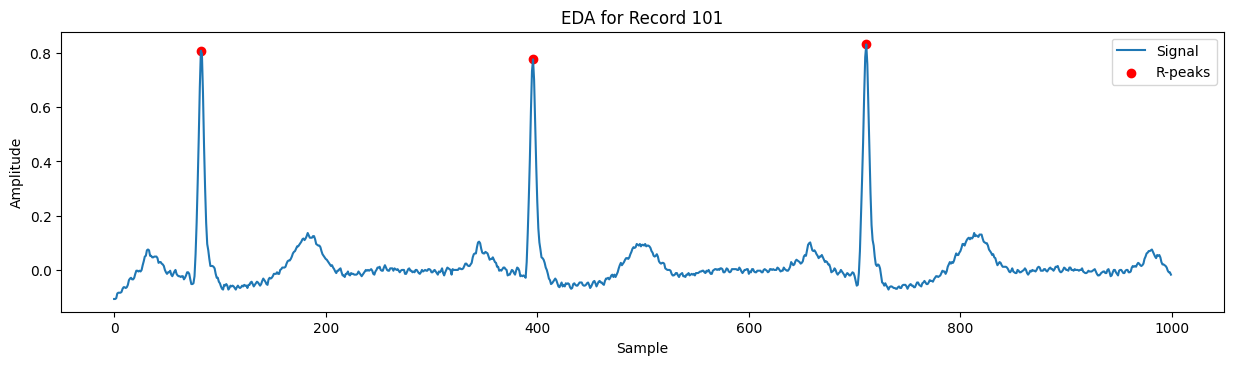

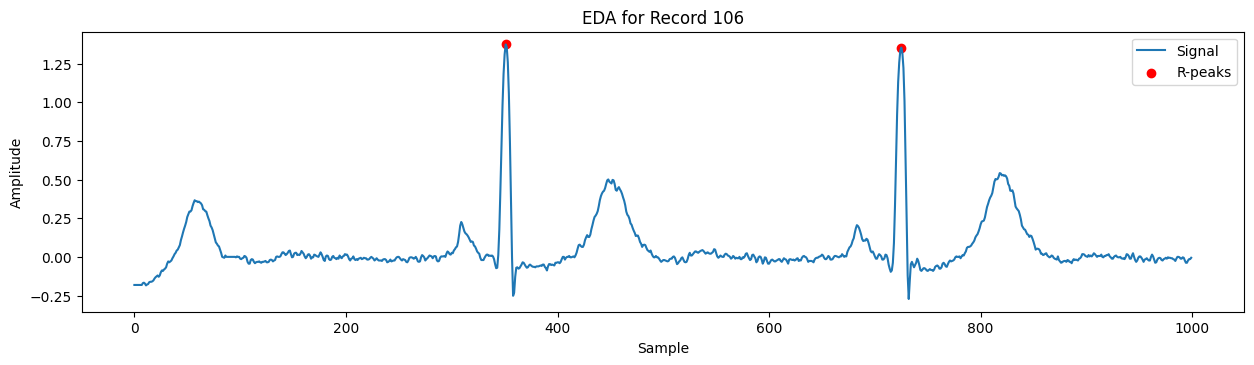

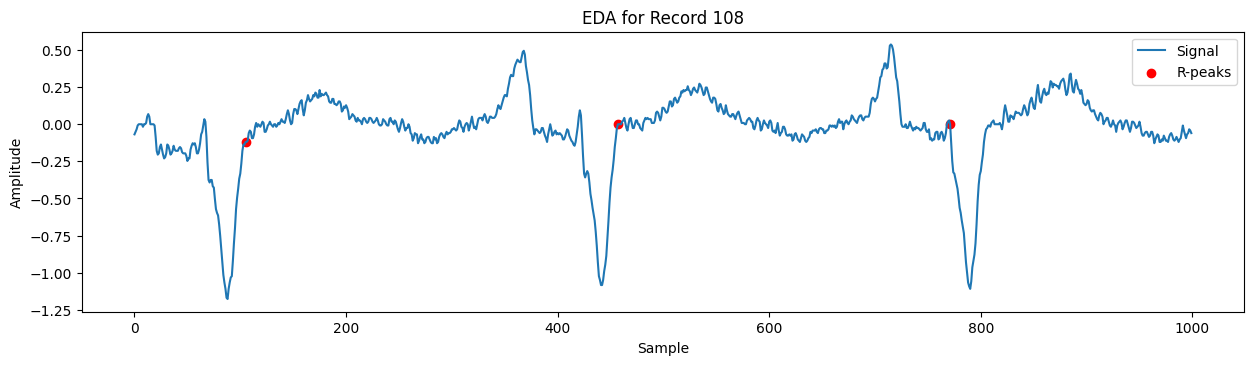

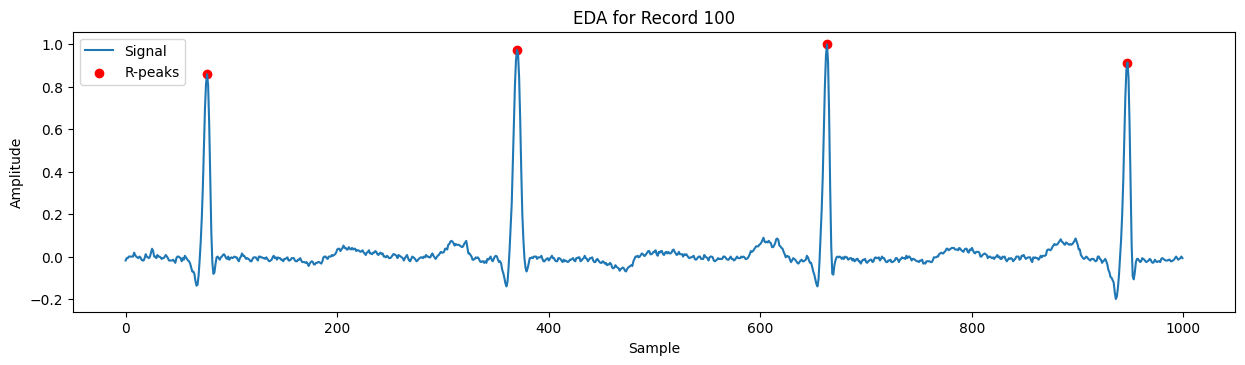

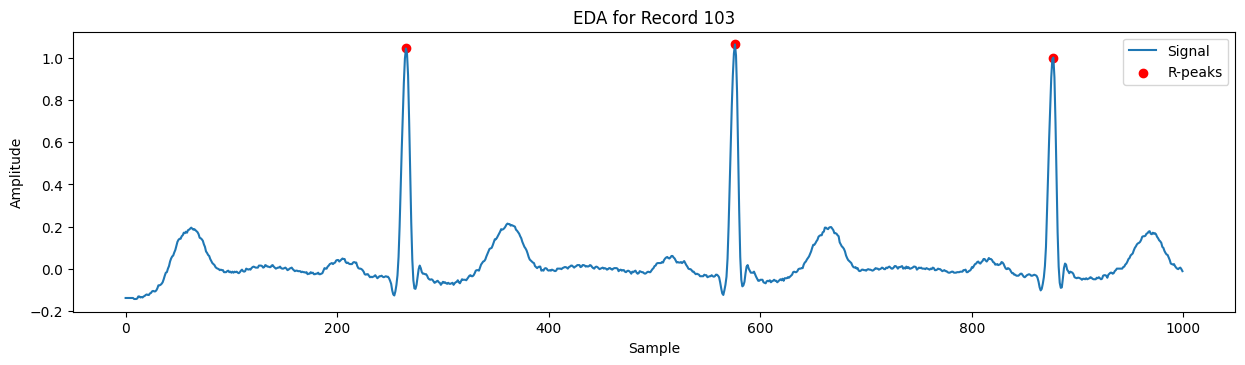

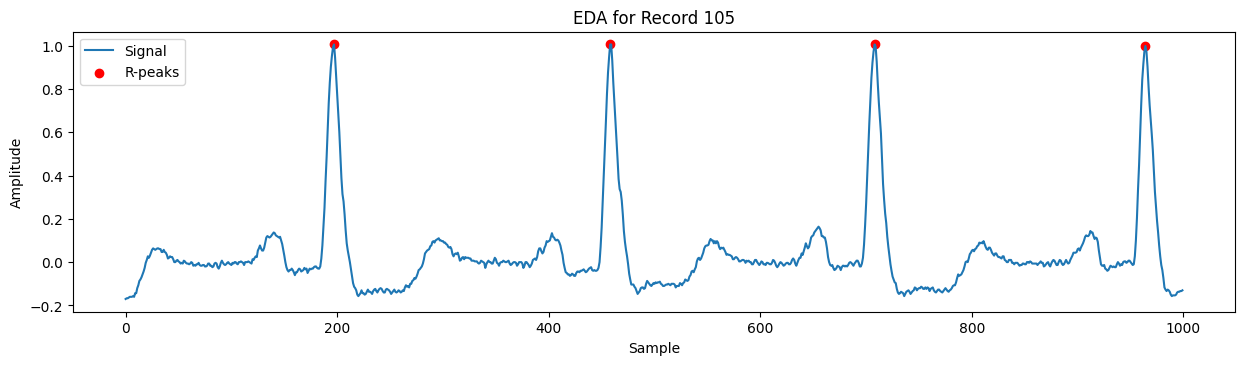

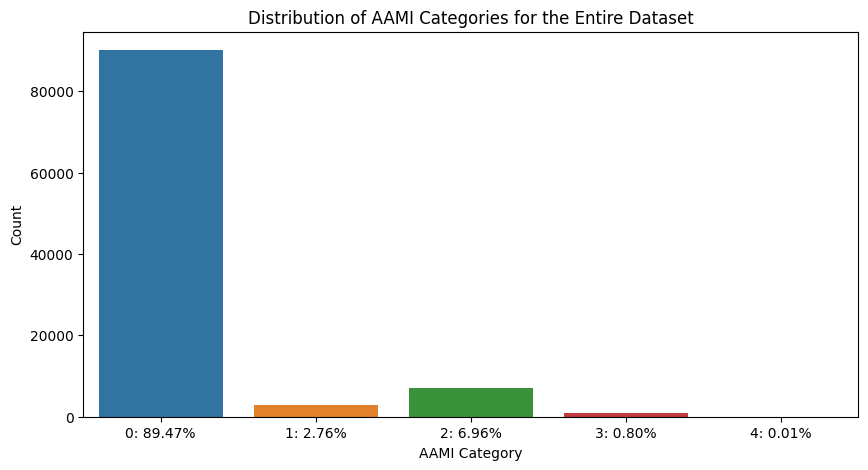

In [20]:
# Load the processed data
with open((PATH / "mitdb.pkl").as_posix(), "rb") as f:
    train_data, test_data = pickle.load(f)

# Function for plotting EDA
def plot_eda(signal, r_peaks, categories, title, num_samples=1000):
    plt.figure(figsize=(15, 8))

    # Plot the signal
    plt.subplot(2, 1, 1)
    plt.plot(signal[:num_samples], label='Signal')
    r_peaks_to_plot = r_peaks[r_peaks < num_samples]
    plt.scatter(r_peaks_to_plot, signal[r_peaks_to_plot], c='r', marker='o', label='R-peaks')
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()

for data in train_data[:3]:
    plot_eda(data['signal'], data['r_peaks'], data['categories'], f"EDA for Record {data['record']}", num_samples=1000)

for data in test_data[:3]:
    plot_eda(data['signal'], data['r_peaks'], data['categories'], f"EDA for Record {data['record']}", num_samples=1000)

plt.figure(figsize=(10, 5))
all_categories = np.concatenate([data['categories'] for data in train_data + test_data])
category_counts = np.bincount(all_categories)
total_samples = len(all_categories)

percentage_labels = [f"{category}: {count/total_samples*100:.2f}%" for category, count in enumerate(category_counts)]

sns.countplot(x=all_categories)
plt.title('Distribution of AAMI Categories for the Entire Dataset')
plt.xlabel('AAMI Category')
plt.ylabel('Count')
plt.xticks(ticks=range(len(category_counts)), labels=percentage_labels)
plt.show()

MODEL

In [17]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 7)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pooling1 = nn.MaxPool2d(5)
        self.pooling2 = nn.MaxPool2d(3)
        self.pooling3 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(68, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x1, x2):
        x1 = F.relu(self.bn1(self.conv1(x1)))  # (16 x 94 x 94)
        x1 = self.pooling1(x1)  # (16 x 18 x 18)
        x1 = F.relu(self.bn2(self.conv2(x1)))  # (32 x 16 x 16)
        x1 = self.pooling2(x1)  # (32 x 5 x 5)
        x1 = F.relu(self.bn3(self.conv3(x1)))  # (64 x 3 x 3)
        x1 = self.pooling3(x1)  # (64 x 1 x 1)
        x1 = x1.view((-1, 64))  # (64,)
        x = torch.cat((x1, x2), dim=1)  # (68,)
        x = F.relu(self.fc1(x))  # (32,)
        x = self.fc2(x)  # (4,)
        return x

In [18]:
callbacks = [
Initializer("[conv|fc]*.weight", fn=torch.nn.init.kaiming_normal_),
Initializer("[conv|fc]*.bias", fn=partial(torch.nn.init.constant_, val=0.0)),
LRScheduler(policy=StepLR, step_size=5, gamma=0.1),
EpochScoring(scoring=make_scorer(f1_score, average="macro"), lower_is_better=False, name="valid_f1"),
]
net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
        MyModule,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        lr=0.001,
        max_epochs=30,
        batch_size=1024,
        train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
        verbose=1,
        device="cuda",
        callbacks=callbacks,
        iterator_train__shuffle=True,
        optimizer__weight_decay=0,
)
net.fit({"x1": x1_train, "x2": x2_train}, y_train)
y_true, y_pred = y_test, net.predict({"x1": x1_test, "x2": x2_test})

  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr     dur
-------  ------------  -----------  ----------  ------------  ------  ------
      1        0.3026       0.9451      0.4719        0.2165  0.0010  8.7024
      2        0.1383       0.9506      0.5178        0.1747  0.0010  7.0808
      3        0.0975       0.9554      0.5675        0.1537  0.0010  7.2691
      4        0.0760       0.9560      0.5604        0.1554  0.0010  7.1190
      5        0.0631       0.9566      0.6430        0.1804  0.0010  7.0835
      6        0.0554       0.9678      0.6585        0.1463  0.0001  7.1051
      7        0.0513       0.9687      0.6616        0.1425  0.0001  7.3669
      8        0.0500       0.9692      0.6636        0.1409  0.0001  7.1161
      9        0.0484       0.9697      0.6644        0.1400  0.0001  7.0841
     10        0.0477       0.9701      0.6686        0.1426  0.0001  7.4336
     11        0.0470       0.9697      0.6648        0.1419  0.0000  7.1839

Confuse Matrix

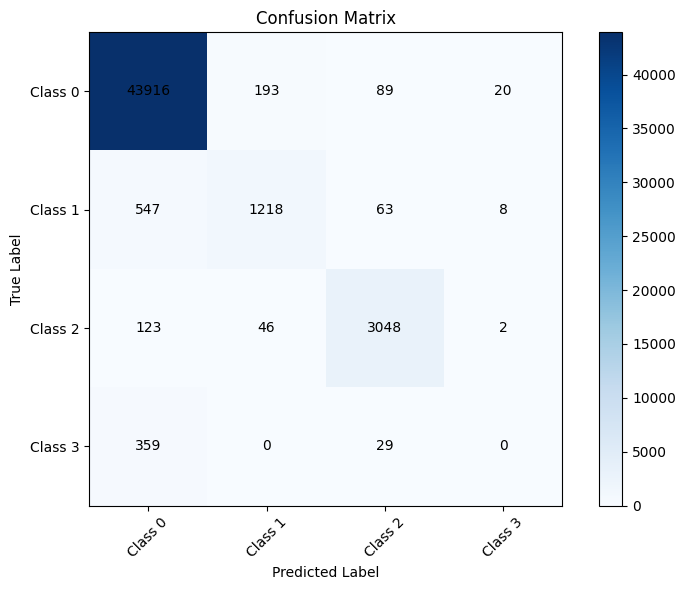

              precision    recall  f1-score   support

           0     0.9771    0.9932    0.9851     44218
           1     0.8360    0.6634    0.7398      1836
           2     0.9439    0.9469    0.9454      3219
           3     0.0000    0.0000    0.0000       388

    accuracy                         0.9702     49661
   macro avg     0.6893    0.6509    0.6676     49661
weighted avg     0.9621    0.9702    0.9657     49661



In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Modify based on your actual class labels

tick_marks = range(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the values on the plot
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

# Display classification report
print(classification_report(y_true, y_pred, digits=4))
